# Introduction
For my final project, we will be comparing the performance of VGG-16 model vs ResNet50 in the context of Pistachio classification. In this Pistachio Image Dataset, we are provided 2148 sample images for two species of pistachios: Siirt Pistachio and Kirmizi Pistachio. Since the dataset is not already partitioned into test and train datasets, we will do so. Along the way we will augment the data so that our models are more accurate.

Split-Folders is a library designed to split data into Train, Test, Validation from a directory.
This transformed dataset is saved in /kaggle/working/output/ directory.

In [58]:
#Installing the required package

!pip install split-folders

In [126]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os, cv2
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
sns.set_theme(style="white", palette=None)

# Loading the Dataset

In [107]:
data_dir = "../input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/"

We are splitting the dataset in the following format:

* 80% Training
* 10% Validation
* 10% Test

In [108]:
splitfolders.ratio(data_dir, output="output", seed=5829, ratio=(.8, .1, .1))

Copying files: 2148 files [00:02, 1056.57 files/s]


In [109]:
train_path = './output/train'
test_path = './output/test'
val_path = './output/val'

# Preprocessing

Let's check the images.

In [110]:
img = mpimg.imread('./output/train/Kirmizi_Pistachio/kirmizi 113.jpg')

In [111]:
img.shape

(600, 600, 3)

The original images have a size of (600,600) so we will be using 512 as the image size to keep the size as a multiple of 64.
We could use resizing further but since our dataset is small, we will not be resizing it a lot and using 512 for our purpose.

In [112]:
img_size = 512
batch = 16

In [113]:
labels = []
for i in os.listdir(train_path):
    labels += [i]

In [114]:
labels

['Siirt_Pistachio', 'Kirmizi_Pistachio']

# Displaying Images

In [122]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(5):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,5,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file}')
        plt.imshow(img)

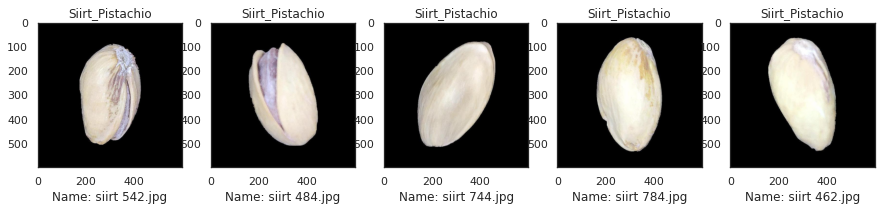

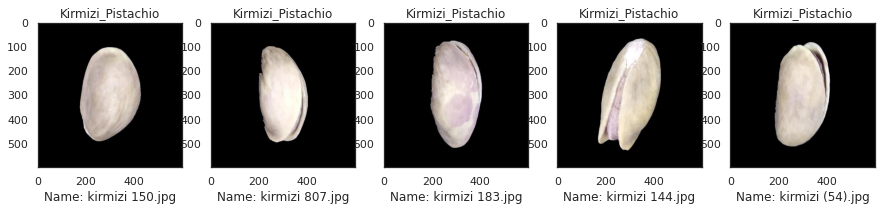

In [127]:
for label in labels:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

# Image Augmentation

We perform image augmentation since the dataset is small. This way, the CNN can learn from more examples that are created from the existing images with only slight variations.

In [70]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [71]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

val_generator = test_val_datagen.flow_from_directory(directory = val_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 1717 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Found 217 images belonging to 2 classes.


In [72]:
data_train = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)
data_test = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=0,
    color_mode="rgb",
    image_size=(img_size,img_size),
    batch_size=32,
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Found 2148 files belonging to 2 classes.
Using 429 files for validation.


# Building the models

Here, I am building a VGG-16 model pre-trained on the imagenet dataset and adapting it to our use case. This involves removing the final layer from the base model which has 1000 outputs as it VGG-16 is built to classify 1000 classes. In its place, we add some dense layers which use relu activation interspersed with dropout layers. The final layer is a Dense layer with the softmax activation and only 2 outputs: Siirt or Kirmizi.

In [74]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model_vgg16.trainable = False

# add custom top layers
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model_vgg_16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# confirm unfrozen layers
for layer in model_vgg_16.layers:
    if layer.trainable==True:
        print(layer)

In [75]:
# model_vgg_16.summary()

### Visual Representation of the model layers

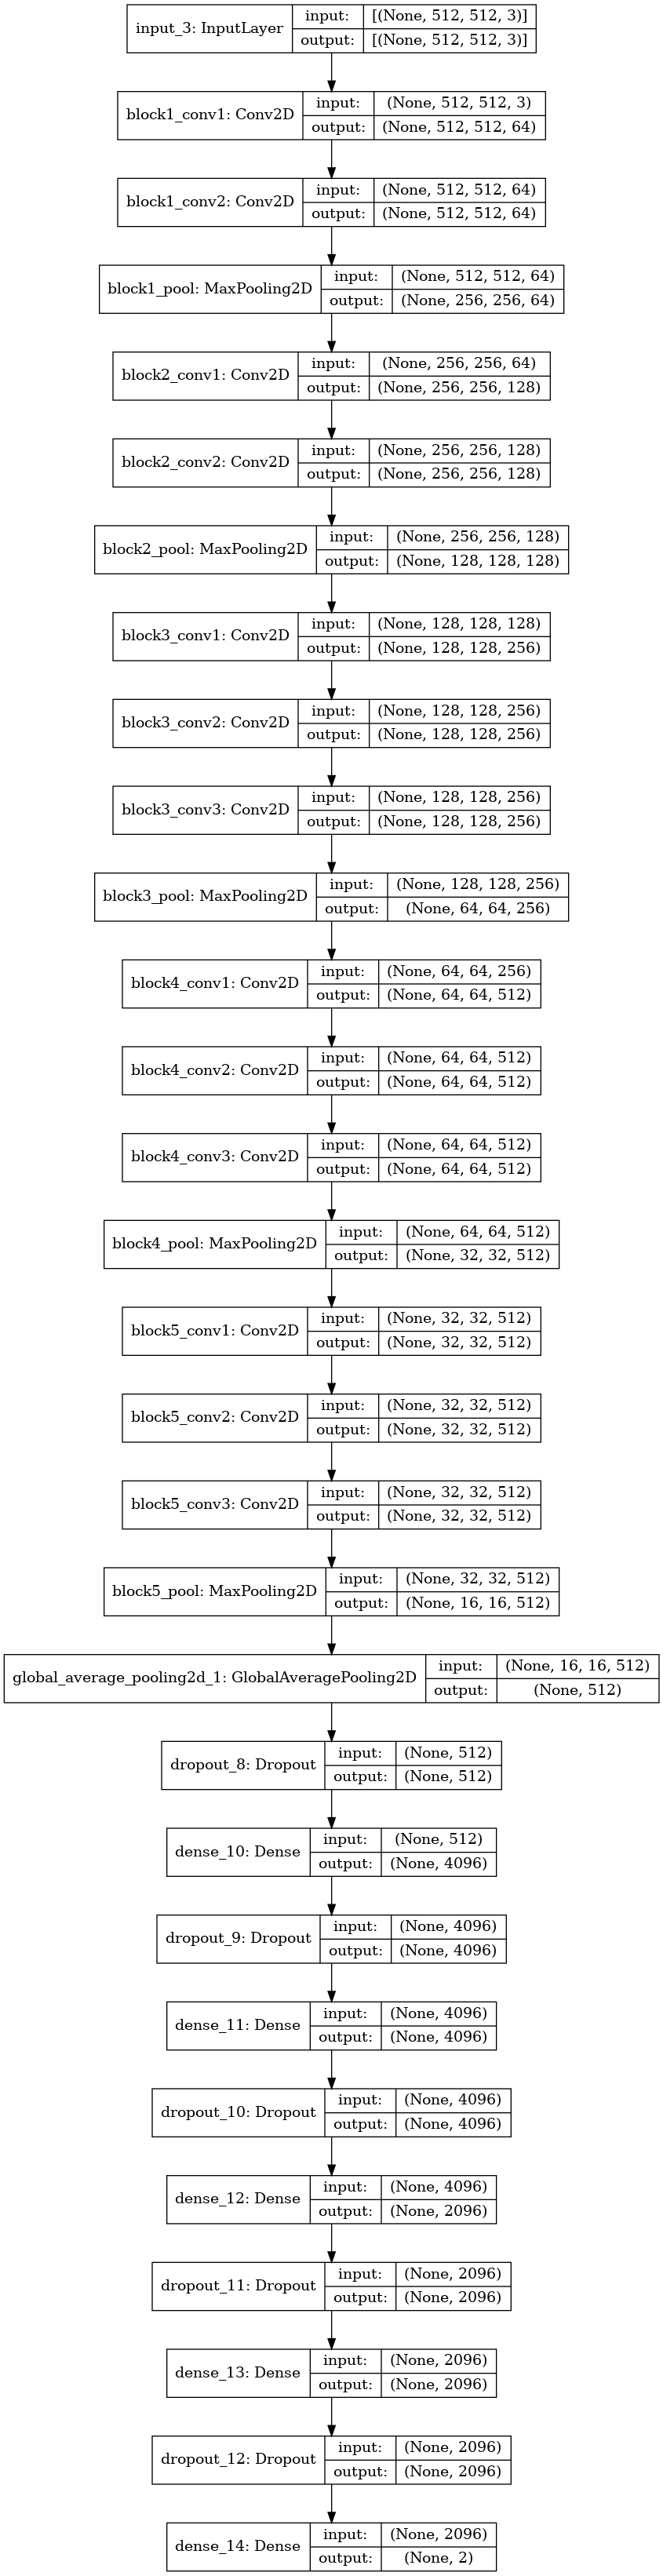

In [76]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_vgg_16, to_file='convnetvgg16.png', show_shapes=True,show_layer_names=True)
Image(filename='convnetvgg16.png') 

Here, we'll register a callback to continually monitor the validation loss and stop the training of model when it overfits. This callback will stop the training when there is no improvement in the loss for three consecutive epochs. When you don't strike gold for 3 turns, move to another place and try again. Also, everytime the callback activates, the model with the best accuracy is saved.

In [77]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
    ModelCheckpoint('model_vgg_16.hdf5', save_best_only = True)
]

In [78]:
opt = Adam(learning_rate = 0.0001)
model_vgg_16.compile(
  loss = 'categorical_crossentropy',
  optimizer = opt,
  metrics = ['accuracy']
)

In [79]:
history_vgg_16 = model_vgg_16.fit(
    data_train,
    epochs = 15,
    validation_data = data_test,
    validation_steps = int(0.1 * len(data_test)),
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/15
54/54 [==============================] - 24s 407ms/step - loss: 0.4790 - accuracy: 0.7766 - val_loss: 0.1282 - val_accuracy: 0.9375
Epoch 2/15
54/54 [==============================] - 23s 402ms/step - loss: 0.2972 - accuracy: 0.8854 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 3/15
54/54 [==============================] - 23s 406ms/step - loss: 0.2304 - accuracy: 0.8965 - val_loss: 0.2327 - val_accuracy: 0.8438
Epoch 4/15
54/54 [==============================] - 23s 408ms/step - loss: 0.2315 - accuracy: 0.9034 - val_loss: 0.1665 - val_accuracy: 0.9062
Epoch 5/15
54/54 [==============================] - 23s 401ms/step - loss: 0.1928 - accuracy: 0.9156 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 6/15
54/54 [==============================] - 23s 407ms/step - loss: 0.1677 - accuracy: 0.9360 - val_loss: 0.1133 - val_accuracy: 0.9375
Epoch 7/15
54/54 [==============================] - 22s 398ms/step - loss: 0.1549 - accuracy: 0.9378 - val_loss: 0.2227 - val_accuracy: 0.9375

# Evaluation

In [81]:
from tensorflow.keras.models import load_model

### Loading Best Model Saved during Callback

In [132]:
saved_model_vgg_16 = load_model('./model_vgg_16.hdf5')

In [133]:
def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

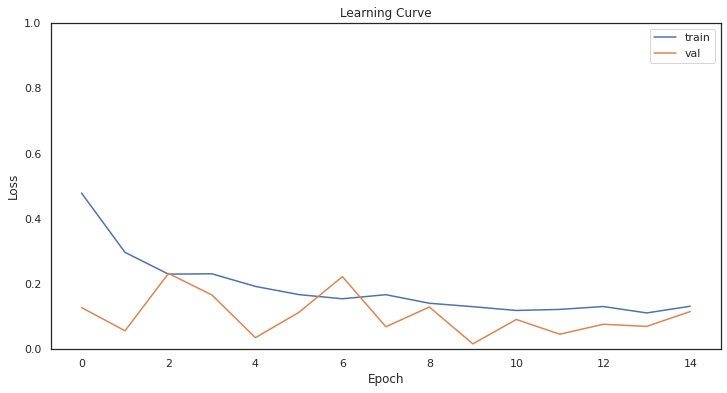

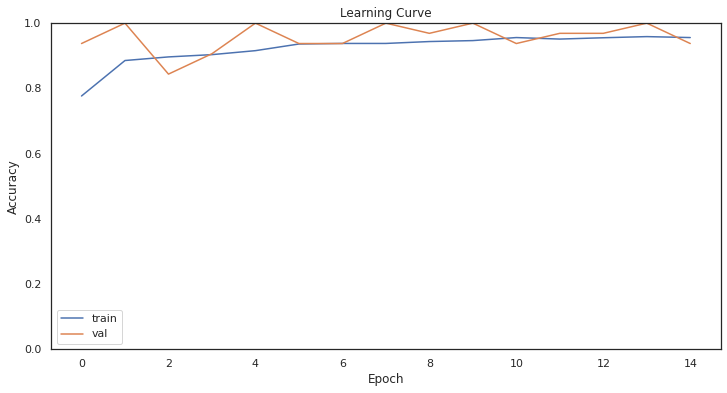

In [134]:
learning_curve(history_vgg_16,'loss', ylim=(0,1))
learning_curve(history_vgg_16, 'accuracy', ylim=(0,1))

In [135]:
test_loss, test_acc = saved_model_vgg_16.evaluate(data_test, steps=len(data_test), verbose=1)
print('Loss: %.3f' % (test_loss))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

14/14 [==============================] - 6s 363ms/step - loss: 0.0788 - accuracy: 0.9697
Loss: 0.079
Accuracy: 96.970


In [136]:
predictions = np.array([])
labels =  np.array([])
for x, y in data_test:
    predictions = np.concatenate([predictions, np.argmax(saved_model_vgg_16.predict(x),axis=1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [137]:
classes = []
for i in os.listdir(train_path):
    classes+=[i]

classes

['Siirt_Pistachio', 'Kirmizi_Pistachio']

### Function for calculating F1-Score

In [138]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

### Function for plotting Confusion Matrix

In [139]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('/kaggle/working/img1.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

### Function for Calculating Classification Report and other metrics

In [140]:
def cal_score(model, key):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if key==1:
        confusion_matrix_plot(matrix)

[[230   3]
 [ 10 186]]


F1 Score: 0.9696457172144276


                   precision    recall  f1-score   support

  Siirt_Pistachio       0.96      0.99      0.97       233
Kirmizi_Pistachio       0.98      0.95      0.97       196

         accuracy                           0.97       429
        macro avg       0.97      0.97      0.97       429
     weighted avg       0.97      0.97      0.97       429



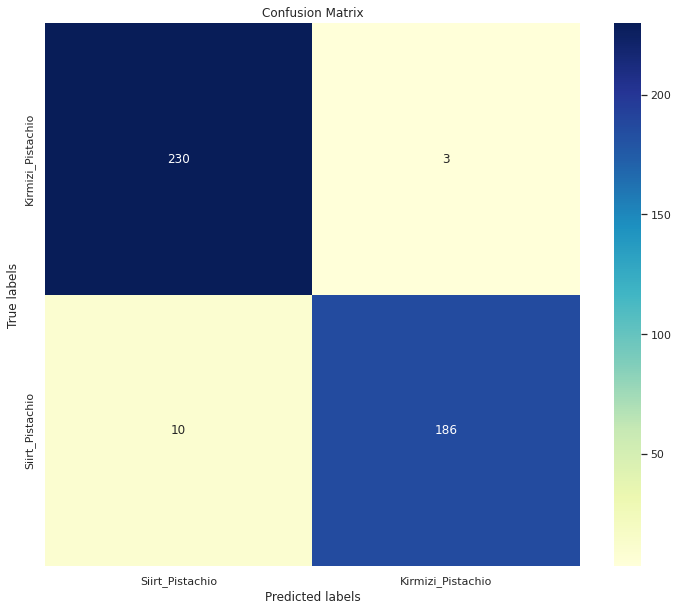

In [141]:
cal_score(saved_model_vgg_16, 1)

# ResNet50

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 billion Floating points operations. It is a widely used ResNet model.

In [93]:
from tensorflow.keras.applications import ResNet50

model_res50 = Sequential()
model_res50.add(
    ResNet50(
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'
    )
)

model_res50.add(Dense(2, activation = 'softmax'))
# Freeze layer
model_res50.layers[0].trainable = False 

# Show summary
model_res50.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [94]:
model_res50.compile(
    optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

history = model_res50.fit(
    data_train,
    epochs = 7,
    validation_data = data_test,
    validation_steps = int(0.1 * len(data_test)),
    verbose =  1,
    callbacks = callbacks
)

Epoch 1/7
54/54 [==============================] - 24s 385ms/step - loss: 0.5644 - accuracy: 0.7382 - val_loss: 0.4260 - val_accuracy: 0.8125
Epoch 2/7
54/54 [==============================] - 21s 356ms/step - loss: 0.3042 - accuracy: 0.9104 - val_loss: 0.3139 - val_accuracy: 0.9375
Epoch 3/7
54/54 [==============================] - 21s 367ms/step - loss: 0.2280 - accuracy: 0.9442 - val_loss: 0.1531 - val_accuracy: 1.0000
Epoch 4/7
54/54 [==============================] - 21s 368ms/step - loss: 0.1827 - accuracy: 0.9564 - val_loss: 0.1244 - val_accuracy: 0.9375
Epoch 5/7
54/54 [==============================] - 20s 361ms/step - loss: 0.1576 - accuracy: 0.9593 - val_loss: 0.0872 - val_accuracy: 1.0000
Epoch 6/7
54/54 [==============================] - 20s 360ms/step - loss: 0.1408 - accuracy: 0.9639 - val_loss: 0.2173 - val_accuracy: 0.8750
Epoch 7/7
54/54 [==============================] - 21s 370ms/step - loss: 0.1281 - accuracy: 0.9651 - val_loss: 0.1030 - val_accuracy: 0.9688


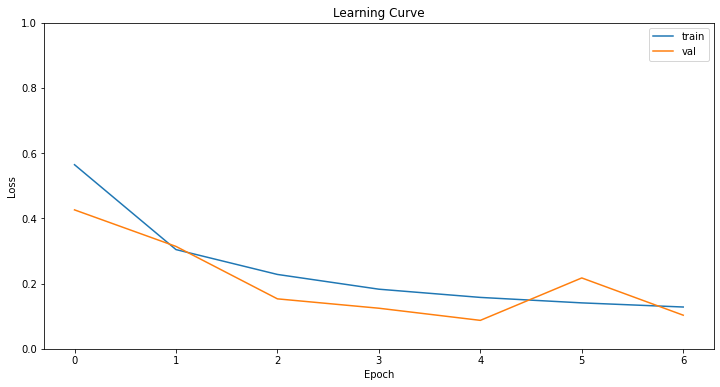

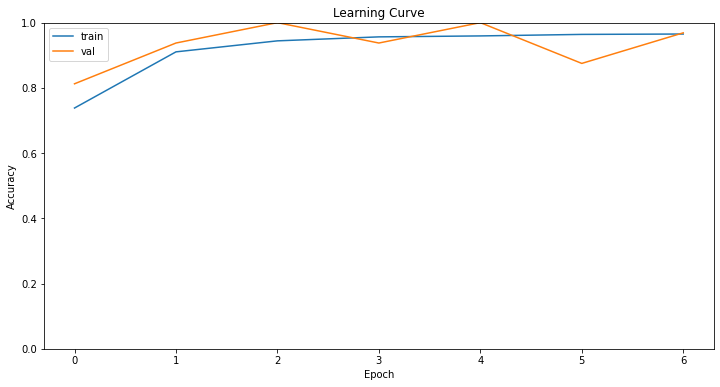

In [95]:
learning_curve(history,'loss', ylim = (0,1))
learning_curve(history, 'accuracy', ylim = (0,1))

In [96]:
test_loss_res50, test_acc_res50 = model_res50.evaluate(data_test, steps=len(data_test), verbose=1)
print('Loss: %.3f' % (test_loss_res50))
print('Accuracy: %.3f' % (test_acc_res50 * 100.0))

14/14 [==============================] - 6s 322ms/step - loss: 0.1548 - accuracy: 0.9441
Loss: 0.155
Accuracy: 94.406


In [98]:
# Saving the model
model_res50.save('drowsines_model_ResNet50_Binary2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [99]:
predictions = np.array([])
labels =  np.array([])
for x, y in data_test:
    predictions = np.concatenate([predictions, np.argmax(model_res50.predict(x),axis=1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

[[221   5]
 [ 19 184]]


F1 Score: 0.9438973044123258


                   precision    recall  f1-score   support

  Siirt_Pistachio       0.92      0.98      0.95       226
Kirmizi_Pistachio       0.97      0.91      0.94       203

         accuracy                           0.94       429
        macro avg       0.95      0.94      0.94       429
     weighted avg       0.95      0.94      0.94       429



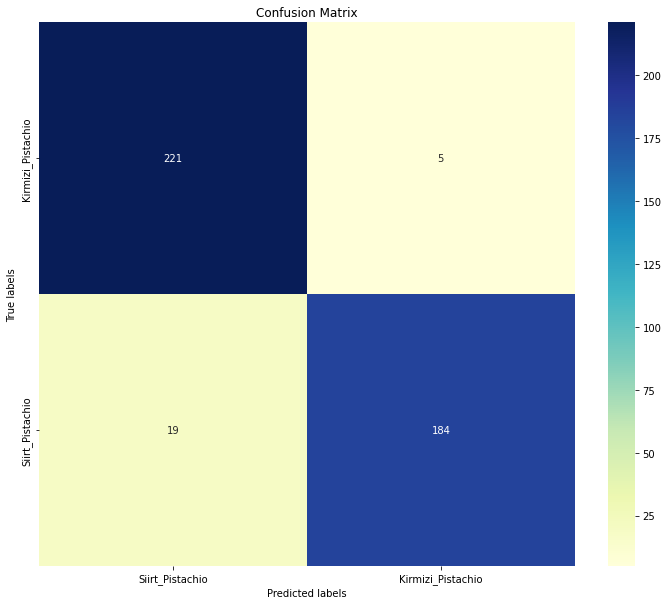

In [100]:
cal_score(model_res50, 1)

From the F1-scores of the two models, which measures the percentage of correct predictions that a ML model has made, we can clearly see that VGG-16 performs better on this dataset.